In [37]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import ast as ast
from task_2_helpers import *
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import parallel_coordinates


### Data Read

In [2]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliBussRatings.parquet', engine='pyarrow')
print(df_data_res.shape)
print(df_data_res.columns)
# df_data_res.head(5)


(123414, 15)
Index(['business_id', 'postal_code_int', 'attributes_list', 'hours_list',
       'categories_list', 'latitude', 'longitude', 'id', 'user_id', 'rating',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')


### 2.2 Food Trends and Restaurant styles

We can analyse the food trends by two steps:

1 -  We have the category information of the restaurants and their rating. We can distribute these ratings among the categories and take an average per category. This approach gives us a generic liking of the certain categories. However, it doesn't show the trend. We also count the number of time a category appeared in the dataset. This shows the interest of the people to the certain style of restaurants. Using the average rating and the frequency we identify the most trendy restaurant categories. 

2 - From there we can identify the food trends. Most of the categories are related with the food style. We select the most trending 10 food style. We then calculate their corresponding rating by time and draw the evolution of the ratings by time


In [3]:
data_cat_ratings =  df_data_res[['id','date','categories_list', 'rating']]
data_cat_rating_single = data_cat_ratings.explode('categories_list')
data_cat_rating_single['mean_rating'] = data_cat_rating_single[['categories_list', 'rating']]\
                        .groupby('categories_list')['rating'].transform('mean')

data_cat_rating_single['frequency'] = data_cat_rating_single['categories_list'].map(data_cat_rating_single['categories_list'].value_counts())
data_cat_rating_single['rating_freq_ratio'] = data_cat_rating_single['frequency']/len(data_cat_ratings)
data_cat = data_cat_rating_single[['categories_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'categories_list':'categories'}) #.set_index('date')

data_cat = data_cat[(data_cat['rating_freq_ratio'] > 0.05) ]
# data_cat.hist()

data_cat.sort_values(by='mean_rating', ascending=False, inplace=True)
data_cat.head(20)


,categories,frequency,mean_rating,rating_freq_ratio
176519,specialty food,7207,4.072430,0.058397
176363,cafes,7019,4.055706,0.056874
176005,vegetarian,6366,4.024505,0.051582
176160,desserts,6404,4.011555,0.051890
175591,beer,6226,4.008834,0.050448
175591,wine & spirits,6226,4.008834,0.050448
176522,coffee & tea,11148,3.974435,0.090330
175692,japanese,6805,3.907127,0.055140
176522,food,37842,3.888642,0.306626
174802,asian fusion,6733,3.877469,0.054556


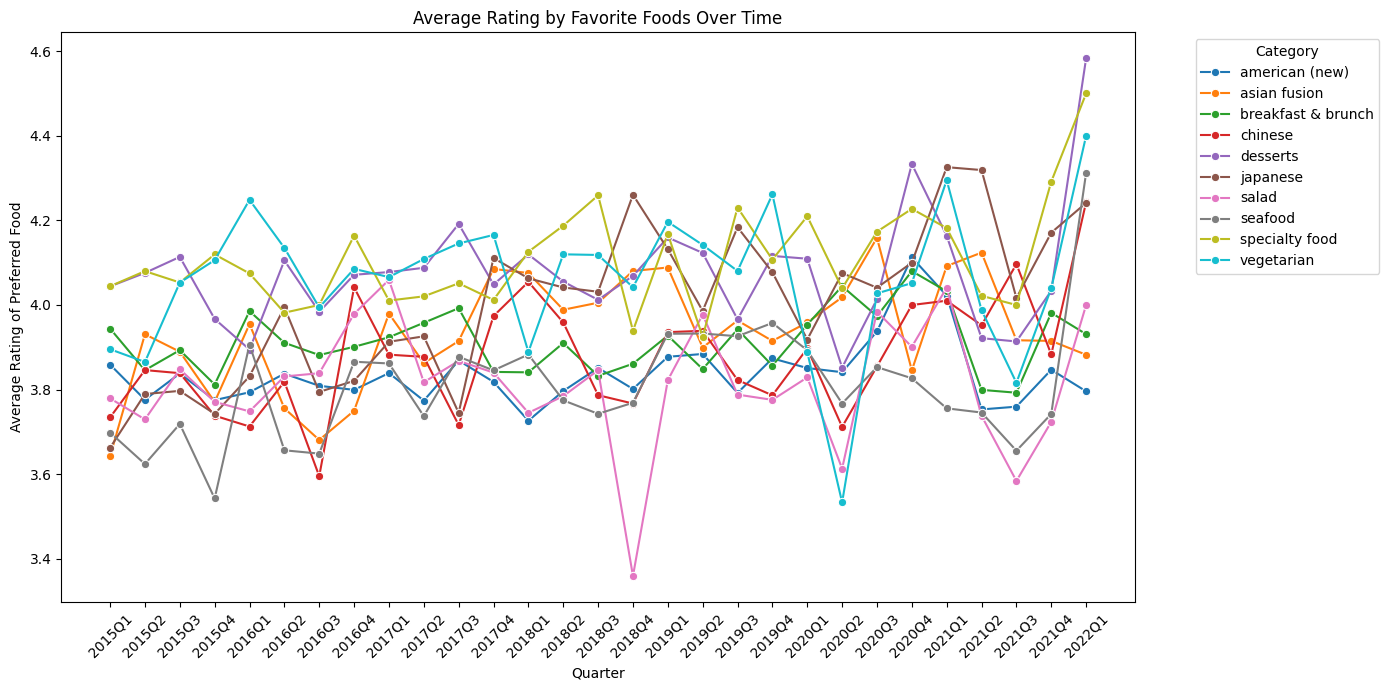

In [4]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])
data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)
df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).rating.mean().reset_index()

df_pivot = df_grouped.pivot(index='quarter', columns='categories', values='rating')
df_pivot = df_pivot.sort_index()

plot_trending_figures(df_grouped,  x='quarter', y='rating', hue='categories', marker='o',
                    legend='Category', xlabel='Quarter', ylabel='Average Rating of Preferred Food',
                    title='Average Rating by Favorite Foods Over Time')


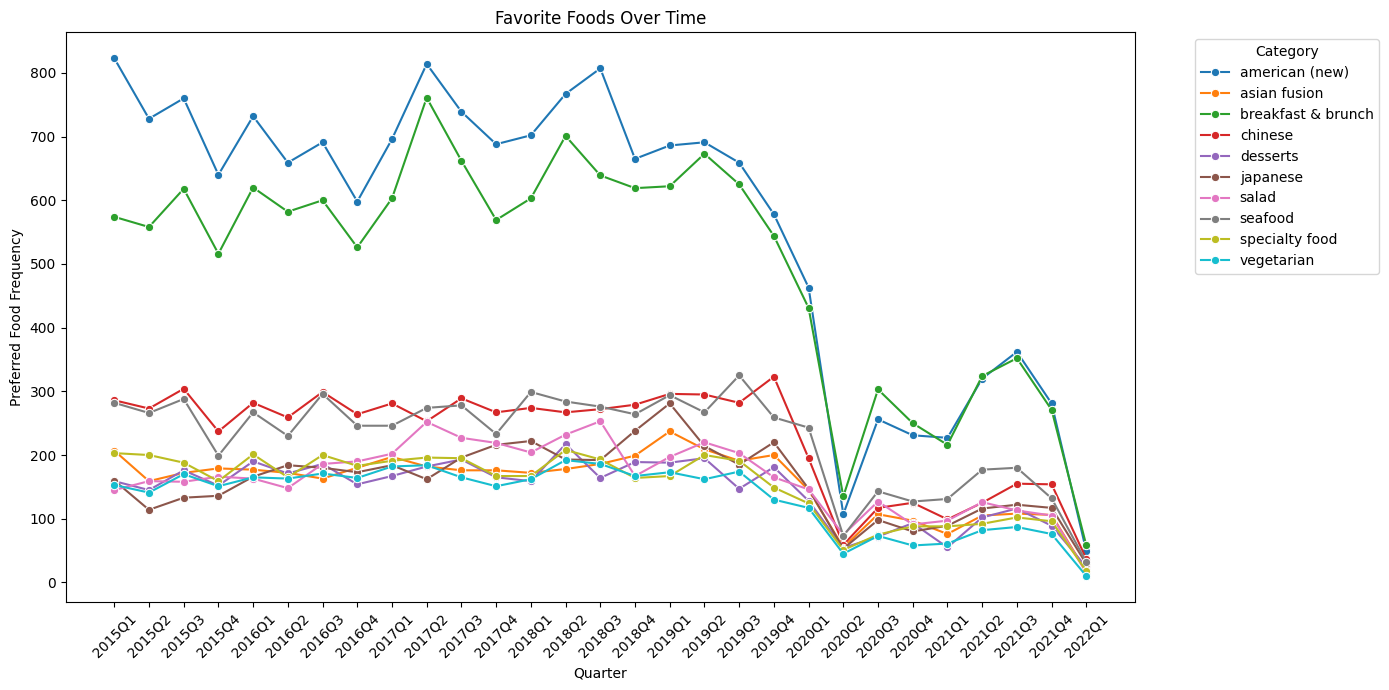

In [5]:
chosen_cat=['specialty food', 'vegetarian', 'desserts', 'japanese', 'asian fusion', 'breakfast & brunch', 'chinese', 'salad', 'seafood', 'american (new)']

data_cat_rating_chosen = data_cat_rating_single.loc[data_cat_rating_single.categories_list.isin(chosen_cat), ['date','rating', 'categories_list']]\
                            .rename(columns={'categories_list':'categories'})

data_cat_rating_chosen['date'] = pd.to_datetime(data_cat_rating_chosen['date'])
data_cat_rating_chosen = data_cat_rating_chosen[data_cat_rating_chosen['date'] > '2015-01-01']
data_cat_rating_chosen['quarter'] = data_cat_rating_chosen['date'].dt.to_period('Q').astype(str)
df_grouped = data_cat_rating_chosen.groupby(['quarter', 'categories']).size().reset_index(name='frequency')



plot_trending_figures(df_grouped,  x='quarter', y='frequency', hue='categories', marker='o',
                    legend='Category', xlabel='Quarter', ylabel='Preferred Food Frequency', 
                    title='Favorite Foods Over Time')


#### 2.3 Suggestions for the restaurants

We can apply the similar method to the attributes of the restaurants. We can find the most appreciated attributes and see their combined effect on the rating.

In [38]:
data_att_ratings =  df_data_res[['id','date','attributes_list', 'rating']] 
data_att_rating_single = data_att_ratings.explode('attributes_list')
data_att_rating_single['mean_rating'] = data_att_rating_single[['attributes_list', 'rating']]\
                        .groupby('attributes_list')['rating'].transform('mean')

data_att_rating_single['frequency'] = data_att_rating_single['attributes_list'].map(data_att_rating_single['attributes_list'].value_counts())
data_att_rating_single['rating_freq_ratio'] = data_att_rating_single['frequency']/len(data_att_ratings)
data_att = data_att_rating_single[['attributes_list', 'frequency', 'mean_rating', 'rating_freq_ratio']]\
            .drop_duplicates(keep='last').rename(columns={'attributes_list':'attributes'}) #.set_index('date')

data_att = data_att[(data_att['rating_freq_ratio'] > 0.05) ]
data_att.sort_values(by='mean_rating', ascending=False, inplace=True)
data_att.head(5)
# data_att_generic = data_att[data_att.mean_rating > 3.8].sort_values(by='rating_freq_ratio', ascending=False)
# data_att_generic = data_att[(data_att.mean_rating > 3.8) & (data_att.rating_freq_ratio < 0.9)].sort_values(by='rating_freq_ratio', ascending=False)

,attributes,frequency,mean_rating,rating_freq_ratio
175989,ByAppointmentOnly,20975.0,4.029273,0.169956
176422,BYOB,18047.0,3.962653,0.146231
176363,GoodForMeal-brunch,14885.0,3.953846,0.120610
176420,DogsAllowed,58831.0,3.952797,0.476696
176420,Ambience-trendy,17443.0,3.941352,0.141337


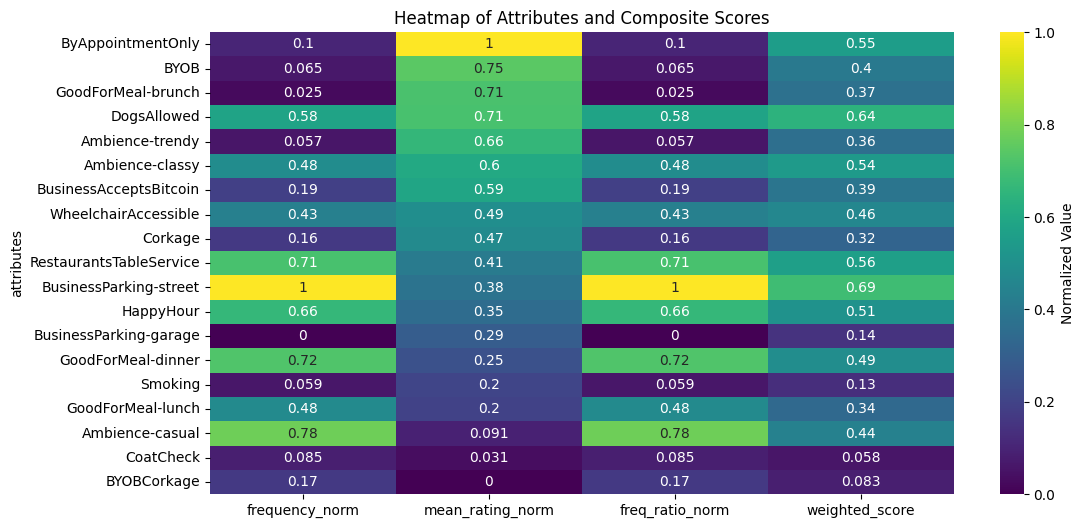

In [42]:
df = data_att[(data_att.mean_rating >= 3.75) & (data_att.rating_freq_ratio < 0.9) & (data_att.rating_freq_ratio > 0.10)].sort_values(by='mean_rating', ascending=False)

# Normalize the metrics
scaler = MinMaxScaler()
df[['frequency_norm', 'mean_rating_norm', 'freq_ratio_norm']] = scaler.fit_transform(df[['frequency', 'mean_rating', 'rating_freq_ratio']])

# Calculate a weighted score (example weights: frequency=0.3, mean_rating=0.5, freq_ratio=0.2)
weights = {'frequency': 0.25, 'mean_rating': 0.5, 'rating_freq_ratio': 0.25}
df['weighted_score'] = (weights['frequency'] * df['frequency_norm'] +
                        weights['mean_rating'] * df['mean_rating_norm'] +
                        weights['rating_freq_ratio'] * df['freq_ratio_norm'])

# Prepare data for heatmap
heatmap_data = df[['attributes', 'frequency_norm', 'mean_rating_norm', 'freq_ratio_norm', 'weighted_score']].set_index('attributes')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', cbar_kws={'label': 'Normalized Value'})
plt.title('Heatmap of Attributes and Composite Scores')
plt.show()


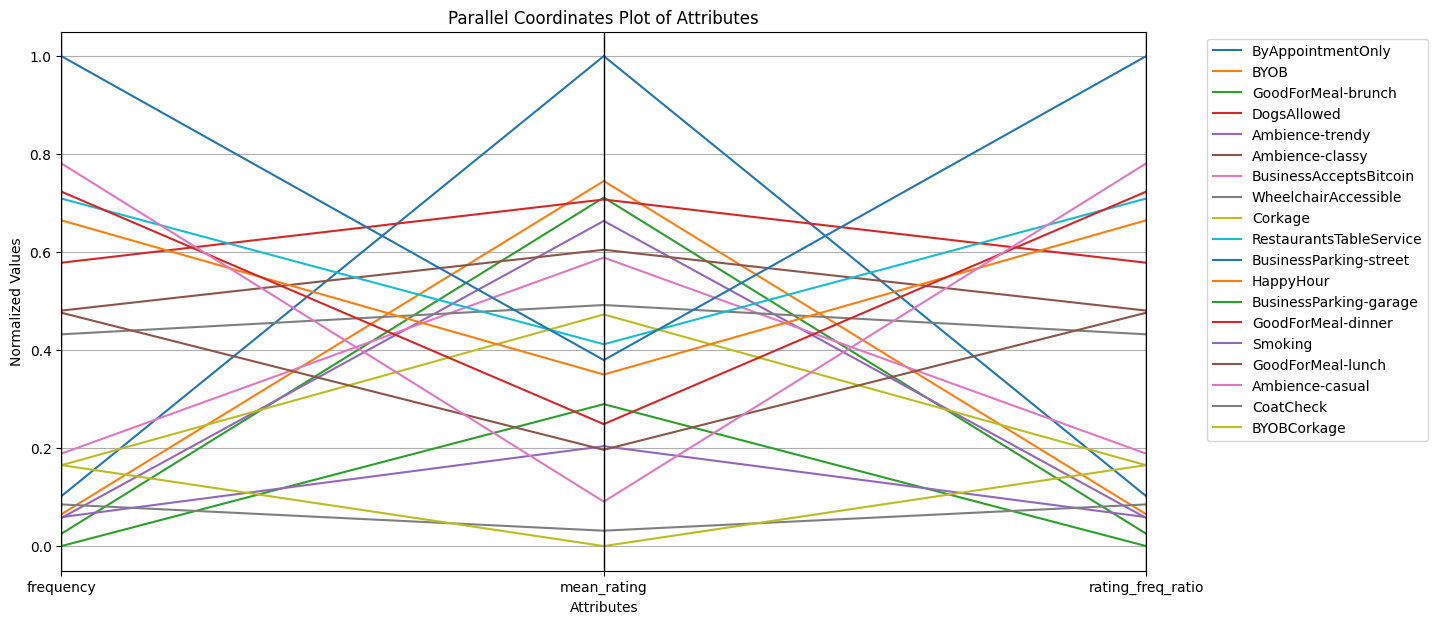

In [40]:
df = data_att[(data_att.mean_rating >= 3.75) & (data_att.rating_freq_ratio < 0.9) & (data_att.rating_freq_ratio > 0.10)].sort_values(by='mean_rating', ascending=False)

# Normalize the metrics
scaler = MinMaxScaler()
df[['frequency', 'mean_rating', 'rating_freq_ratio']] = scaler.fit_transform(df[['frequency', 'mean_rating', 'rating_freq_ratio']])

# Plot parallel coordinates
plt.figure(figsize=(14, 7))
parallel_coordinates(df, 'attributes', color=plt.get_cmap('tab10').colors)
plt.title('Parallel Coordinates Plot of Attributes')
plt.xlabel('Attributes')
plt.ylabel('Normalized Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

